In [2]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Configurar la conexión a la base de datos
host = '<HOST>'
database = '<DATABASE>'
user = '<USER>'
password = '<PASSWORD>'
port = '<PORT>'

# Crear la cadena de conexión
connection_string = f'mysql+mysqlconnector://{user}:{password}@{host}:{port}/{database}'

# Crear la conexión
engine = create_engine(connection_string)

# Definir las tablas a cargar
tablas = ['dim_producto',  
          'fact_venta', 'fact_detalle_venta']

# Cargar las tablas en DataFrames
dataframes = {}
for tabla in tablas:
    query = f'SELECT * FROM {tabla}'
    dataframes[tabla] = pd.read_sql(query, engine)

In [4]:
# Hacer un df que tenga las columnas que nos interesan
productos = dataframes.get("dim_producto")[["producto_id", "precio_lista", "categoria_id", "unidad_medida_id"]]
fac_ventas = dataframes.get("fact_venta")[["venta_id", "monto_total", "empresa_id", "fecha_id"]]
detalle_ventas = dataframes.get("fact_detalle_venta")[["venta_id", "producto_id", "precio_unitario", "cantidad"]]

In [5]:
# Filtrar datos no válidos
productos = productos[productos["precio_lista"] > 0]
fac_ventas = fac_ventas[fac_ventas["monto_total"] > 0]
detalle_ventas.loc[detalle_ventas["cantidad"] < 0, "cantidad"] = 0

In [6]:
# Calcular el promedio de unidades compradas por factura
detalle_ventas_agrupado = detalle_ventas.groupby(by="producto_id")["cantidad"].mean().reset_index()
detalle_ventas_agrupado.columns = ["producto_id", "promedio_compra_factura"]

In [7]:
# Unir los DataFrames de productos y detalle de ventas
productos = pd.merge(productos, detalle_ventas_agrupado, on="producto_id", how="left")
productos["promedio_compra_factura"].fillna(0, inplace=True)

In [8]:
# Preparar los datos para clustering
# Convertir variables categóricas en variables dummy
productos = pd.get_dummies(productos)

# Escalar los datos para normalizar las características
scaler = StandardScaler()
df_escalado = scaler.fit_transform(productos)

In [9]:
# Aplicar K-Means para agrupar los productos
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(df_escalado)
productos["Cluster"] = kmeans.labels_

# Reducir la dimensionalidad con PCA para visualización
pca = PCA(n_components=2)
componentes_principales = pca.fit_transform(df_escalado)
df_pca = pd.DataFrame(data=componentes_principales, columns=["Componente 1", "Componente 2"])
df_pca["Cluster"] = kmeans.labels_

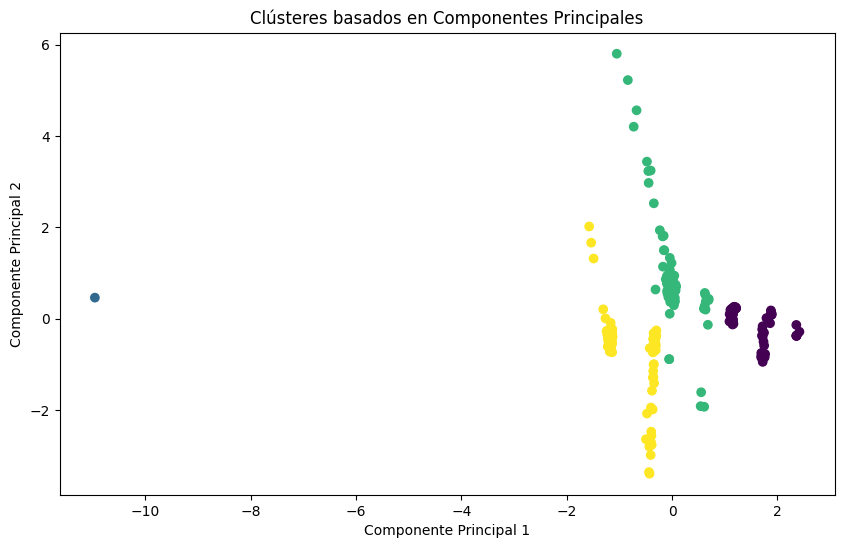

In [10]:
# Visualizar los clústeres en un gráfico de dispersión
plt.figure(figsize=(10,6))
plt.scatter(df_pca["Componente 1"], df_pca["Componente 2"], c=df_pca["Cluster"], cmap="viridis")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("Clústeres basados en Componentes Principales")
plt.show()

In [11]:
# Mostrar estadísticas descriptivas de cada clúster
for i in range(4):
    print(f"Estadísticas descriptivas para el Clúster {i}:")
    print(productos[productos["Cluster"] == i].describe())
    print("-" * 67)

Estadísticas descriptivas para el Clúster 0:
       producto_id  precio_lista  categoria_id  unidad_medida_id  \
count    72.000000     72.000000     72.000000              72.0   
mean    991.458333     20.854167      7.472222               1.0   
std      31.686376     17.965036      0.649425               0.0   
min     950.000000      3.000000      7.000000               1.0   
25%     967.750000      9.500000      7.000000               1.0   
50%     985.500000     16.000000      7.000000               1.0   
75%    1003.250000     24.000000      8.000000               1.0   
max    1066.000000     75.000000      9.000000               1.0   

       promedio_compra_factura  Cluster  
count                72.000000     72.0  
mean                  0.974398      0.0  
std                   0.575970      0.0  
min                   0.000000      0.0  
25%                   1.000000      0.0  
50%                   1.087121      0.0  
75%                   1.332566      0.0  
max   